In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class Generator(nn.Module):
    def __init__(self, noise_dim):
        super(Generator, self).__init__()
        self.noise_dim = noise_dim
        self.main = nn.Sequential(
            nn.Linear(noise_dim, 7 * 7 * 256),
            nn.ReLU(True),
            nn.Unflatten(1, (256, 7, 7)),
            nn.ConvTranspose2d(256, 128, 5, stride=1, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 1, 5, stride=2, padding=2, output_padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

In [3]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [4]:
NOISE_DIM = 100

generator = Generator(NOISE_DIM)
discriminator = Discriminator()

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
generator = generator.to(device)
discriminator = discriminator.to(device)

In [6]:
criterion = nn.BCEWithLogitsLoss()

generator_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

NUM_EPOCHS = 2
BATCH_SIZE = 256

In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

'''
print(len(train_dataset[0]))
print(train_dataset[0][1])
print(len(train_dataset[0][0]))
print(len(train_dataset[0][0][0]))
print(len(train_dataset[0][0][0][0]))
#print(train_dataset[0][0][0][0])
'''


100%|██████████| 9.91M/9.91M [00:01<00:00, 6.03MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 160kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.51MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.92MB/s]


'\nprint(len(train_dataset[0]))\nprint(train_dataset[0][1])\nprint(len(train_dataset[0][0]))\nprint(len(train_dataset[0][0][0]))\nprint(len(train_dataset[0][0][0][0]))\n#print(train_dataset[0][0][0][0])\n'

In [8]:
for epoch in range(NUM_EPOCHS):
    for i, data in enumerate(train_loader):
        real_images, _ = data
        real_images = real_images.to(device)

        real_labels = torch.ones(real_images.size(0), 1, device=device)
        fake_labels = torch.zeros(real_images.size(0), 1, device=device)

        discriminator_optimizer.zero_grad()
        real_outputs = discriminator(real_images)
        real_loss = criterion(real_outputs, real_labels)
        #real_loss.backward()

        noise = torch.randn(real_images.size(0), NOISE_DIM, device=device)    # classifying real or fake images only
        fake_images = generator(noise)
        fake_outputs = discriminator(fake_images.detach())
        fake_loss = criterion(fake_outputs, fake_labels)
        #fake_loss.backward()
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        discriminator_optimizer.step()

        generator_optimizer.zero_grad()
        #fake_labels = torch.ones(real_images.size(0), 1, device=device)
          # generating images to cheat discriminator
          # use new variable gen_images here instead of old variable fake_images
        gen_images = generator(noise)
        gen_outputs = discriminator(gen_images)
        gen_loss = criterion(gen_outputs, real_labels)
        gen_loss.backward()
        generator_optimizer.step()

        if i % 10 == 0:
            print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Step [{i+1}/{len(train_loader)}], '
                  f'Discriminator Loss: {real_loss.item() + fake_loss.item():.4f}, '
                  f'Generator Loss: {gen_loss.item():.4f}')

Epoch [1/2], Step [1/235], Discriminator Loss: 1.4067, Generator Loss: 0.7591
Epoch [1/2], Step [11/235], Discriminator Loss: 0.9218, Generator Loss: 1.1869
Epoch [1/2], Step [21/235], Discriminator Loss: 0.8524, Generator Loss: 1.0863
Epoch [1/2], Step [31/235], Discriminator Loss: 0.6151, Generator Loss: 1.9552
Epoch [1/2], Step [41/235], Discriminator Loss: 0.4171, Generator Loss: 1.9086
Epoch [1/2], Step [51/235], Discriminator Loss: 0.2611, Generator Loss: 2.4428
Epoch [1/2], Step [61/235], Discriminator Loss: 0.2127, Generator Loss: 2.6037
Epoch [1/2], Step [71/235], Discriminator Loss: 0.1543, Generator Loss: 2.9938
Epoch [1/2], Step [81/235], Discriminator Loss: 1.0857, Generator Loss: 1.4655
Epoch [1/2], Step [91/235], Discriminator Loss: 0.7761, Generator Loss: 2.3299
Epoch [1/2], Step [101/235], Discriminator Loss: 0.9379, Generator Loss: 0.9928
Epoch [1/2], Step [111/235], Discriminator Loss: 0.9442, Generator Loss: 1.8566
Epoch [1/2], Step [121/235], Discriminator Loss: 0.

tensor([[-1.0349],
        [-1.2191],
        [-1.0229],
        [-1.2153],
        [-1.0527],
        [-1.1950],
        [-1.2681],
        [-1.4190],
        [-1.1109],
        [-1.1997],
        [-1.0813],
        [-1.0317],
        [-1.3170],
        [-1.1028],
        [-1.4851],
        [-1.0972]], grad_fn=<AddmmBackward0>)
16
Detached Tensor Shape: torch.Size([16, 1, 28, 28])
tensor([4, 7, 4, 4, 7, 9, 7, 7, 1, 3, 2, 8, 5, 3, 9, 8])


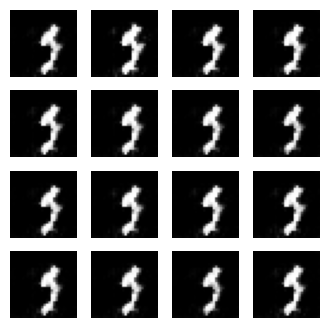

In [9]:
def generate_and_save_images(model, dis_model, epoch, noise):
    model.eval()
    dis_model.eval()
    with torch.no_grad():
        fake_images = model(noise).cpu()
        fake_images = fake_images.view(fake_images.size(0), 28, 28)
        #print(fake_outputs = discriminator(fake_images.detach()))

        fig = plt.figure(figsize=(4, 4))
        for i in range(fake_images.size(0)):
            plt.subplot(4, 4, i+1)
            plt.imshow(fake_images[i], cmap='gray')
            plt.axis('off')

        #plt.savefig(f'image_at_epoch_{epoch+1:04d}.png')
        plt.show()

test_noise = torch.randn(16, NOISE_DIM, device=device)
generator.eval()
test_gen = generator(test_noise)

print(discriminator(test_gen.detach()))
print(len(test_gen))

display_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
for images, labels in display_loader:
    # Detach the image tensor
    images = images.to(device)
    detached_images = images.detach()
    print("Detached Tensor Shape:", detached_images.shape)
    print(labels)
    #print(torch.ones(images.size(0), 1, device=device))
    #print(discriminator(detached_images))
    break

#print(len(torch.tensor([train_dataset[i][0] for i in range(16)])))
#print(  train_dataset[0][:1] )
generate_and_save_images(generator, discriminator, NUM_EPOCHS, test_noise)

In [ ]:
/content/gan_noise.png

NameError: name 'content' is not defined